# Analysis on WILD CLC5, Glu_ext0 & Glu_in-

# Importing libraries

In [32]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering,MiniBatchKMeans,KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import HDBSCAN


from matplotlib.pyplot import figure

import pytraj as pt
import nglview as nv

# Defining functions

In [17]:
def switch(x,D0=3.0,R0=4.0):
    eps = 1e-2
    rd  = (x-D0)/R0
    #rdn = rd**6
    #rdm = rdn*rdn
    #val = (1-rdn+eps)/(1-rdm+2*eps)
    #val[x<D0] = 1.0
    val = np.exp(-rd**2)
    val[x<D0] = 1.0
    return val    

# Loading data

In [14]:
path="/orozco/projects/E-Dent/VERONICA/DIMER_LARGER/mw_metad/analysis_phase2/153_vector"
titles=['wild Gext0','mut Gext0','mut Gext-', 'wild Gext-']
names=['wt_Glu0','mut_Glu0','wt_Glu-', 'mut_Glu-']
walkers=np.arange(0,8)
chains=['A','B']

data=[]
plumed_files=[]
for index,name in enumerate(names):
    data.append([])
    for chain in chains:
        for walker in walkers:
            ftemp='{path}/{system}/{system}.mw{w}.{ch}.analysis.dat'.format(path=path,system=name,w=walker,ch=chain)
            dtemp=pd.read_csv(ftemp,delimiter=" ",comment='#',skipinitialspace=True)
            if (name=='wt_Glu0'):
                dtemp['charge']='0'
            if (name=='wt_Glu-'):
                dtemp['charge']='-1'
            if (name=='mut_Glu0'):
                dtemp['charge']='0'
            if (name=='mut_Glu-'):
                dtemp['charge']='-1'
            dtemp['chain']=chain
            dtemp['system']=name
            dtemp['walker']=walker
            data[index].append(dtemp)
            #plumed_files.append(temp)
data[0][8].head()

,time,d,dc.x,dc.y,dc.z,d_Scen,dc_Scen.x,dc_Scen.y,dc_Scen.z,charge,chain,system,walker
0,0.0,3.207320,0.879997,-1.049999,2.900002,8.189612,-2.390356,-5.525003,-5.552502,0,B,wt_Glu0,0
1,1.0,3.184283,0.649994,-1.240002,2.859993,7.076278,-2.442853,-4.558214,-4.829996,0,B,wt_Glu0,0
2,2.0,3.171656,0.630001,-1.429996,2.760002,7.208850,-2.521072,-4.785716,-4.765358,0,B,wt_Glu0,0
3,3.0,3.273671,0.590000,-1.220001,2.980003,7.837332,-1.900357,-5.329999,-5.422502,0,B,wt_Glu0,0
4,4.0,3.060103,1.040001,-1.510002,2.450005,7.039391,-2.404285,-4.700714,-4.655719,0,B,wt_Glu0,0


# Concatenate data for each system

In [18]:
data_sys=[]
for sys,name in enumerate(names):
    tmp=pd.concat(data[sys][n] for n,m in enumerate(data[sys]))
    data_sys.append(tmp)

In [19]:
data_sys[0].loc[data_sys[0]['chain'] == 'A'].head()

,time,d,dc.x,dc.y,dc.z,d_Scen,dc_Scen.x,dc_Scen.y,dc_Scen.z,charge,chain,system,walker
0,0.0,3.118271,1.900002,0.399998,2.440002,9.313108,-2.489999,-5.674640,-6.952146,0,A,wt_Glu0,0
1,1.0,4.145962,2.750000,-2.519997,1.810005,8.123408,-2.623215,-3.677860,-6.751432,0,A,wt_Glu0,0
2,2.0,3.986238,2.840000,-2.410000,1.419998,7.845474,-3.236786,-3.898572,-5.989642,0,A,wt_Glu0,0
3,3.0,3.960480,3.020004,-2.189999,1.329994,7.991947,-3.375361,-3.987142,-6.048211,0,A,wt_Glu0,0
4,4.0,3.981254,2.980000,-2.320000,1.259995,7.725901,-3.422142,-3.877503,-5.739639,0,A,wt_Glu0,0


In [20]:
data_sys[0][['d','dc.x','dc.y','dc.z']].head()

,d,dc.x,dc.y,dc.z
0,3.118271,1.900002,0.399998,2.440002
1,4.145962,2.750000,-2.519997,1.810005
2,3.986238,2.840000,-2.410000,1.419998
3,3.960480,3.020004,-2.189999,1.329994
4,3.981254,2.980000,-2.320000,1.259995


# Concatenate all data together

In [21]:
allconc=pd.concat((data_sys[n] for n,m in enumerate(data_sys)),ignore_index=True)

# Correlation matrix

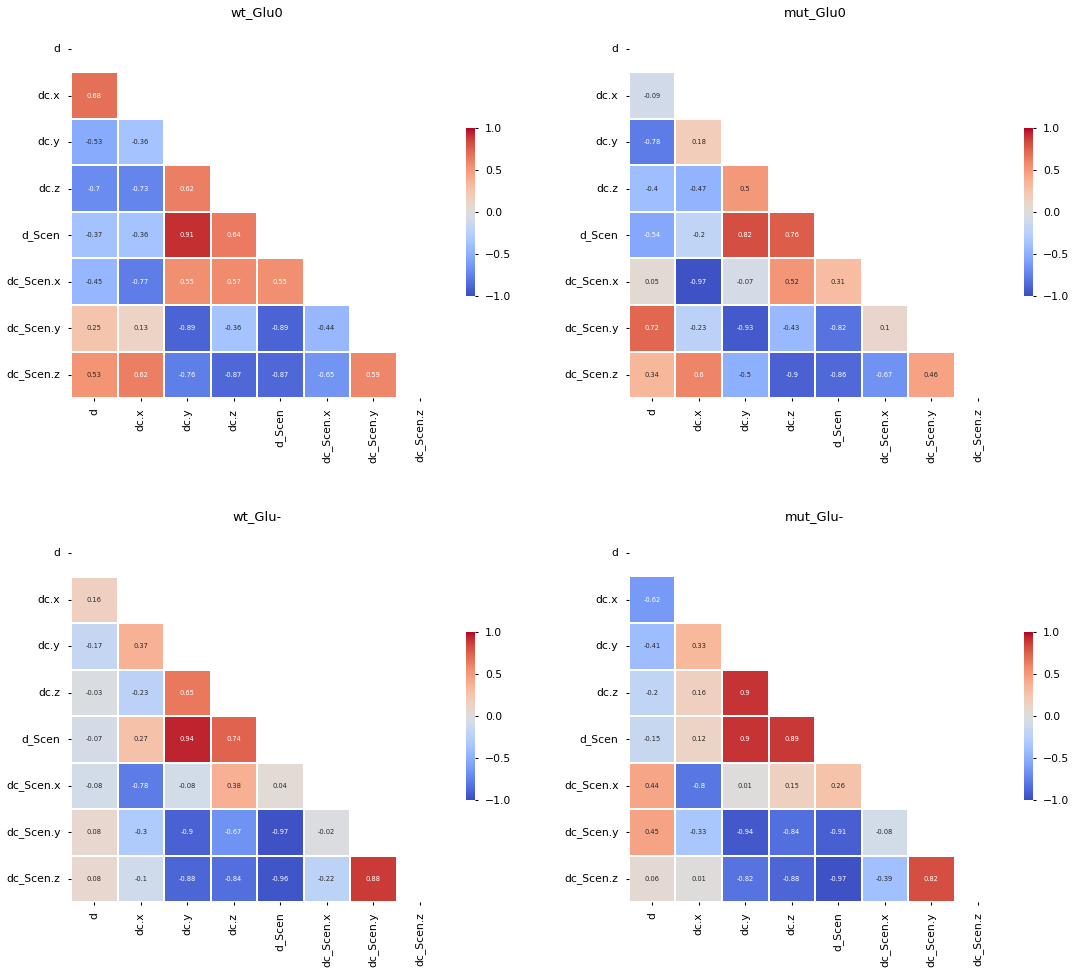

In [22]:
###### corr matrix of dist_data
#corr_matrix = dist_data[:].corr()
corr_matrix=[]
mask=[]
for index,d in enumerate(data_sys):
    corr_matrix.append(d[['d','dc.x','dc.y','dc.z','d_Scen','dc_Scen.x','dc_Scen.y','dc_Scen.z']].corr())

    mask.append(np.zeros_like(corr_matrix[index], dtype=bool))
    mask[index][np.triu_indices_from(mask[index])]=True


f, axis = plt.subplots(2,2,figsize=(22, 20)) 
for i,ax in enumerate(axis.flat):
    
    heatmap=sb.heatmap(corr_matrix[i].round(2), 
                       mask = mask[i],
                       square = True,
                       linewidths = .5,
                       cmap = 'coolwarm',
                       cbar_kws = {'shrink': .4,  'ticks' : [-1, -.5, 0, 0.5, 1]},
                       vmin = -1, 
                       vmax = 1,
                       annot = True,
                       annot_kws = {'size': 8},ax=ax)#add the column names as labels

    ax.set_title(names[i])
#ax.set_xticklabels(corr_matrix.columns)
sb.savefig('dist_covariance.png')

# PCA

Frames=  69160


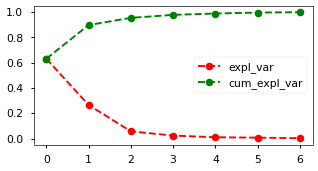

In [39]:
pca = PCA()
select=['d','dc.x','dc.y','dc.z','dc_Scen.x','dc_Scen.y','dc_Scen.z']
len1 = len(allconc)
print('Frames= ',len1)


#get only "select" portion of dist_data
pooled = allconc[select].loc[:,:]


#do pca
#X_pca is a ndarray 
X_pca_pooled = pca.fit_transform(pooled)
X_pca_pooled
#now is a dataframe
X_pca_pooled = pd.DataFrame(X_pca_pooled,columns=['PC%d' % (i+1) for i in range(X_pca_pooled.shape[1])])
X_pca_pooled


f, axis = plt.subplots(1,1,figsize=(6, 3))
axis.plot(pca.explained_variance_ratio_,'ro--', label='expl_var')
axis.plot(np.cumsum(pca.explained_variance_ratio_),'go--', label='cum_expl_var')
axis.legend()
f.savefig('expl_var.png',dpi=80)

# PCA components

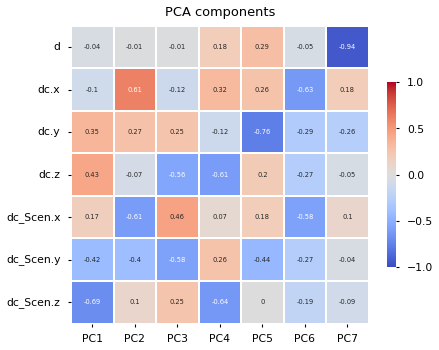

In [42]:
f, ax = plt.subplots(figsize=(8, 10)) 

heatmap = sb.heatmap(pca.components_[:7].T.round(2), 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,  'ticks' : [-1, -.5, 0, 0.5, 1, 1.5, 2.0]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 8})#add the column names as labels

ax.set_yticklabels(pooled.columns, rotation = 0)
ax.set_xticklabels(['PC%d' % (i+1) for i in range(X_pca_pooled.shape[1])] )

sb.set_style({'xtick.bottom': True}, {'ytick.left': True})

plt.title('PCA components')
plt.savefig('pca_comps.png')

#se prendo fino a PCA=9: D4,D5,D9,D10,D11 non conteranno (207-263,207-468,222-OB,216-OC)

In [18]:
print(len(X_pca_pooled))
print(len(allconc))

39618
39618


# Join pca and distances data

In [26]:
pca_data=X_pca_pooled.copy()
pca_data['system']=allconc['system']
pca_data['chain']=allconc['chain']
pca_data['walker']=allconc['walker']
pca_data['charge']=allconc['charge']
pca_data['d']=allconc['d']
pca_data['dc.x']=allconc['dc.x']
pca_data['dc.y']=allconc['dc.y']
pca_data['dc.z']=allconc['dc.z']

In [14]:
pca_data.tail()

,PC1,PC2,PC3,PC4,system,chain,walker,charge,d,dc.x,dc.y,dc.z
39613,1.684871,-2.610645,0.466646,0.396322,mut_Glu-,B,7,-1,3.946294,-2.060001,-3.360004,0.200005
39614,1.832925,-2.347890,0.351781,0.286584,mut_Glu-,B,7,-1,3.852506,-1.750000,-3.430000,0.120003
39615,1.199219,-2.251105,-0.155662,0.326849,mut_Glu-,B,7,-1,3.886863,-1.580002,-3.430000,0.919998
39616,1.165359,-2.411837,0.025456,0.344876,mut_Glu-,B,7,-1,3.890395,-1.799995,-3.340000,0.859993
39617,1.298896,-2.397895,-0.156909,0.439855,mut_Glu-,B,7,-1,4.009163,-1.699997,-3.529999,0.850006


# PCA analysis

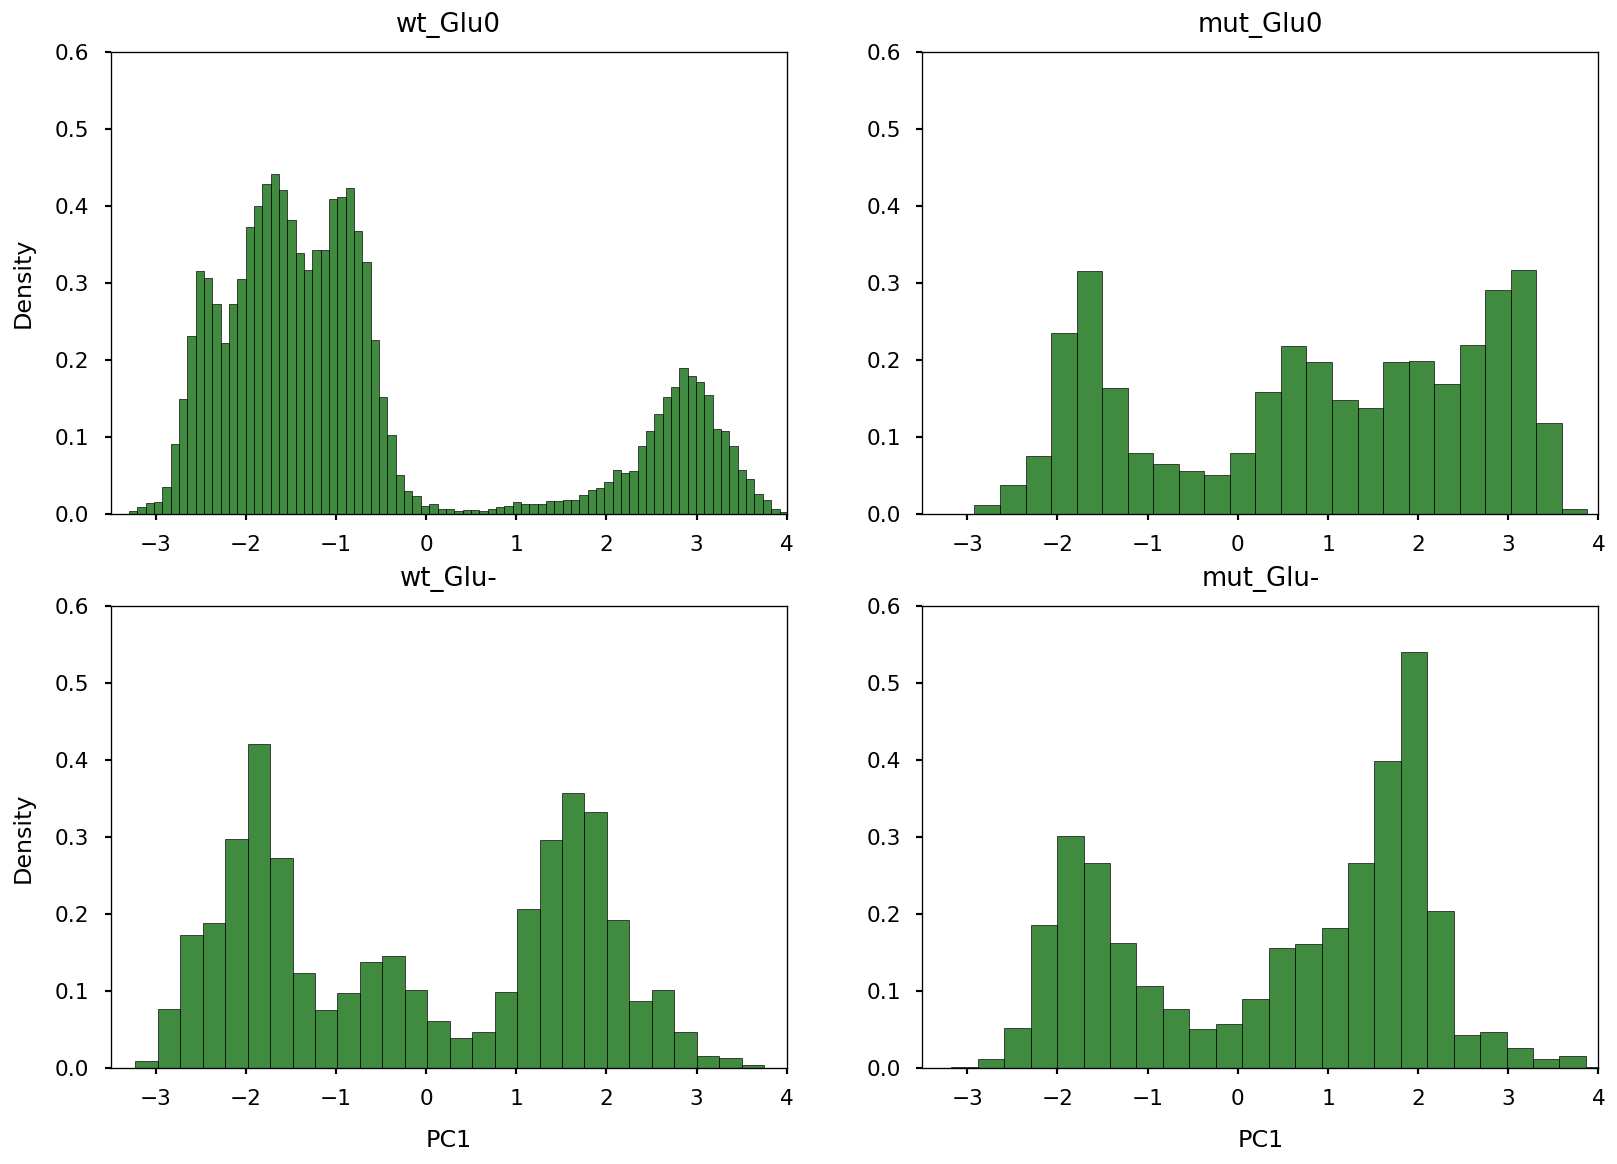

In [43]:
f, axes=plt.subplots(2,2,figsize=(16,11),dpi=120)
for ind,ax in enumerate(axes.flat):
    t=pca_data['PC1'].loc[allconc['system']==names[ind]]
    sb.histplot(data=t,ax=ax,stat='density',color='darkgreen')
    ax.set_title(names[ind])
    ax.set_xlim(-3.5,4)
    ax.set_ylim(0,0.6)
    if ((ind==0) or (ind==2)):
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
    if ((ind==2) or (ind==3)):
        ax.set_xlabel( 'PC1')
    else:
        ax.set_xlabel('')

# Clustering

In [62]:
%%time
#min_cluster_size=n --> I wil obtain clusters with minimum n points, the others go into noise
#min_samples=the higher the more conservative(more noise)
#min_cs=120
#min_s=5
min_cs=700
min_s=1
clusterer = HDBSCAN(min_cluster_size=min_cs, min_samples=min_s, 
                    #alpha=1.5,
                    #cluster_selection_epsilon=0.01,
                    #cluster_selection_method='leaf',
                   )
clusterer.fit(pca_data[['PC1', 'PC2']]) # Use first N PCs
#lab is an array with N data having as value the cluster index
lab = clusterer.labels_
#clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sb.color_palette())
#np.unique(lab,return_counts=True) gives an array with unique values (cluster index) and its occurance 
#zip makes a tuple (cluster index; count)
clupop = dict(zip(*np.unique(lab,return_counts=True)))
noisefrac = clupop[-1]/float(sum(clupop.values()))
print('tot_frames=', sum(clupop.values()))
print(len(lab))
print('populations:', clupop)
print('Noise level %5.1f%% \n' % (noisefrac*100))

lab_ = lab

tot_frames= 69160
69160
populations: {-1: 6751, 0: 35760, 1: 11248, 2: 867, 3: 8771, 4: 5763}
Noise level   9.8% 

CPU times: user 26.3 s, sys: 24.1 ms, total: 26.4 s
Wall time: 26.3 s


In [63]:
lab

array([-1, -1, -1, ...,  4,  4,  4])

In [64]:
np.asarray(sb.color_palette().as_hex())[lab+1]

array(['#1f77b4', '#1f77b4', '#1f77b4', ..., '#8c564b', '#8c564b',
       '#8c564b'], dtype='<U7')

# Clusters population

   clu    pop   perc_pop
0   -1   6751   9.761423
1    0  35760  51.706189
2    1  11248  16.263736
3    2    867   1.253615
4    3   8771  12.682186
5    4   5763   8.332851


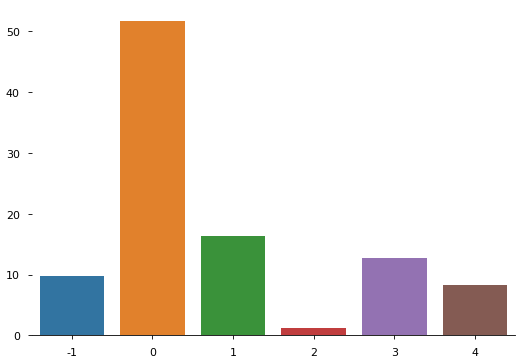

In [65]:
sb.set_context('paper', font_scale=1.5)
clupop_new={'clu':clupop.keys(),'pop':clupop.values()}
df_clupop=pd.DataFrame.from_dict(clupop_new)
#print(df_clupop)
#I add a column to my df_clupop
df_clupop.insert(2,'perc_pop',df_clupop['pop']/len(lab)*100)
print(df_clupop)
pal = sb.color_palette()
sb.barplot(x='clu',y='perc_pop',data=df_clupop,palette=pal)  
colors_ = np.asarray(sb.color_palette().as_hex())[lab+1]
plt.xlabel('')
plt.ylabel('')
sb.despine(left=True)
plt.savefig('barplot_col.png')
#sns.barplot(mydata,hue=clu,color=prova)

pca_data['cluster']=lab
pca_data['color']=colors_
plt.savefig('barplot.png')

In [33]:
sb.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Save cluster data 

In [66]:
data_clust=pca_data[['d','dc.x','dc.y','dc.z','cluster','color','system','walker','chain']]
data_clust.to_pickle('data_clust.pkl')

In [67]:
colors_

array(['#1f77b4', '#1f77b4', '#1f77b4', ..., '#8c564b', '#8c564b',
       '#8c564b'], dtype='<U7')

# Cluster analysis 

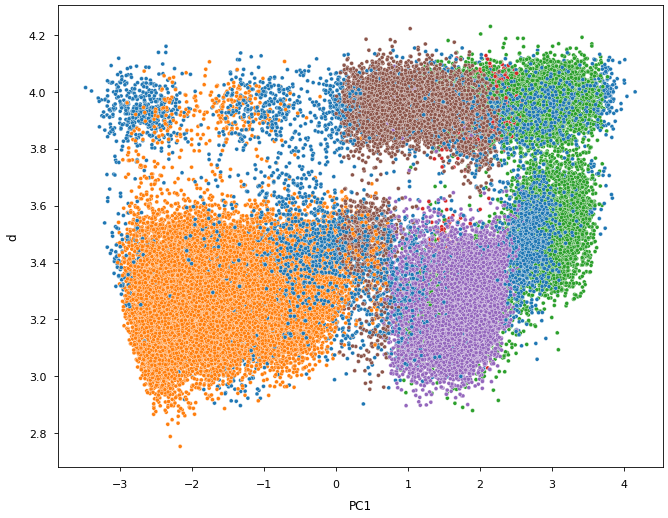

In [72]:
sel=['d']
f, axes=plt.subplots(1,1,figsize=(13,10))

sb.scatterplot(x=pca_data['PC1'],y=pca_data[sel[0]],c=colors_,ax=axes)
axes.set_xlabel('PC1')

    #sb.histplot(data_all[0][sel[ind]],ax=ax)
f.savefig('d_vs_PC1.png')

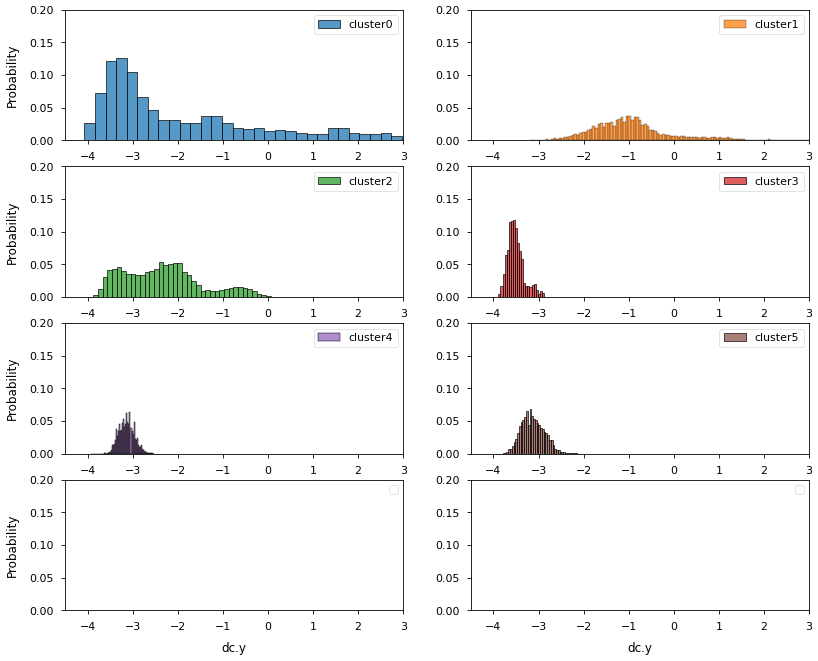

In [73]:
f, axes=plt.subplots(4,2,figsize=(16,13))
for ind,ax in enumerate(axes.flat):
    #sb.scatterplot(x=np.arange(len(data_all[0])),y=data_all[0][sel[ind]],marker=None,ax=ax,c=colors_)
    tp=pca_data['dc.y'].loc[pca_data['cluster']==ind-1]
    sb.histplot(data=tp,ax=ax, color=pal[ind],stat='probability',legend=True,common_norm=True)
    ax.set_label('cluster '+str(ind))
    
    if ((ind==0) or (ind==2)) or (ind==4) or (ind==6):
        ax.set_ylabel('Probability')
    else:
        ax.set_ylabel('')
        
    if ((ind==6) or (ind==7)):
        ax.set_xlabel( 'dc.y')
    else: 
        ax.set_xlabel('')
    
    ax.set_xlim(-4.5,3)
    ax.set_ylim(0,0.2)
    #ax.legend(handles, ['dep-', 'ind-', 'ind+', 'dep+'], title='Stat.ind.')
    ax.legend(['cluster'+str(ind)])
plt.show()
f.savefig('clustering_dy_prob.png')       

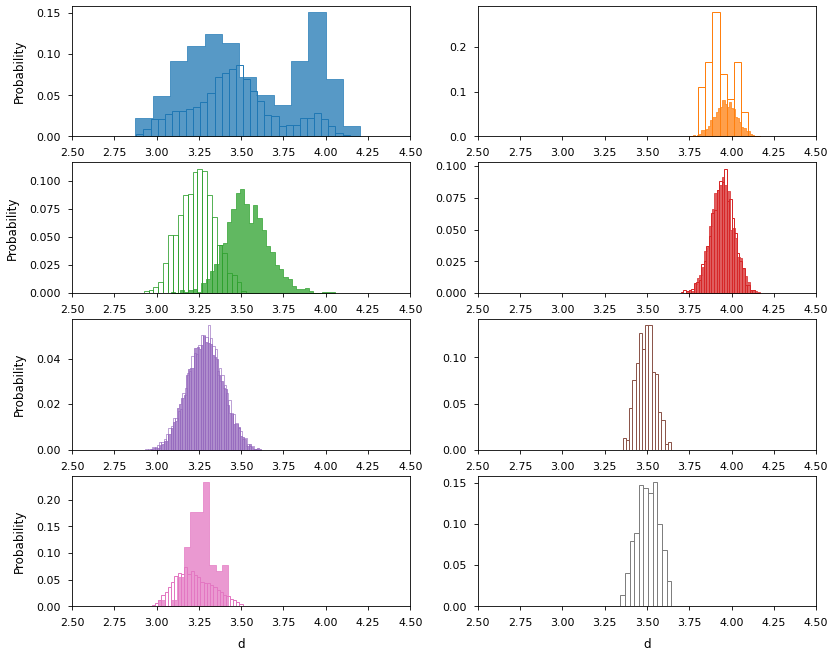

In [433]:
f, axes=plt.subplots(4,2,figsize=(16,13))
for ind,ax in enumerate(axes.flat):
    #sb.scatterplot(x=np.arange(len(data_all[0])),y=data_all[0][sel[ind]],marker=None,ax=ax,c=colors_)
    tp=pca_data['d'].loc[(pca_data['cluster']==ind-1) & (pca_data['charge']=='0')]
    tp2=pca_data['d'].loc[(pca_data['cluster']==ind-1) & (pca_data['charge']=='-1')]
    sb.histplot(data=tp,ax=ax, color=pal[ind],fill=True, element='step',common_norm=True,stat='probability')
    sb.histplot(data=tp2,ax=ax, color=pal[ind],fill=False,stat='probability',common_norm=True)
    if ((ind==0) or (ind==2)) or (ind==4) or (ind==6):
        ax.set_ylabel('Probability')
    else:
        ax.set_ylabel('')
    if ((ind==6) or (ind==7)):
        ax.set_xlabel('d')
    else: 
        ax.set_xlabel('')
    ax.set_xlim(2.5,4.5)
    #ax.set_ylim(0,0.1)
f.savefig('d_chargedivided_prob.png')    

# Print cluster properties

In [477]:
print('cluster              d                  dc.x                 dc.y                dc.z'   )
print('')
for cl in np.arange(0,7):
    clustdata=pca_data.loc[(pca_data['cluster']==cl) & ((pca_data['charge']=='0'))]
    print(cl,'(0)      ', clustdata['d'].mean()*180/np.pi,' ',
                          clustdata['dc.x'].mean()*180/np.pi,'',
                          clustdata['dc.x'].mean()*180/np.pi,'',
                          clustdata['dc.z'].mean()*180/np.pi,'')
for cl in np.arange(0,7):    
    clustdata=pca_data.loc[(pca_data['cluster']==cl) & ((pca_data['charge']=='-1'))]
    print(cl,'(-1)     ', clustdata['d'].mean()*180/np.pi,' ',
                        clustdata['dc.x'].mean()*180/np.pi,'',
                        clustdata['dc.x'].mean()*180/np.pi,'',
                        clustdata['dc.z'].mean()*180/np.pi,'')
    
    
#allconc['153chi1'].loc[allconc['cluster']==2].mean()


cluster              d                  dc.x                 dc.y                dc.z

0 (0)       227.06129131335052   149.83789799662114  149.83789799662114  -7.539851562540021 
1 (0)       202.3995759418587   139.12768088254288  139.12768088254288  -80.3624749757287 
2 (0)       226.01808394063207   -127.44052271403565  -127.44052271403565  49.62577010295285 
3 (0)       188.22018090397341   22.1327753473068  22.1327753473068  168.29150669387565 
4 (0)       nan   nan  nan  nan 
5 (0)       186.8586919851674   -27.463801171488814  -27.463801171488814  37.15948401732005 
6 (0)       nan   nan  nan  nan 
0 (-1)      225.37229617944263   88.47422490703747  88.47422490703747  -2.244054458156537 
1 (-1)      185.57095531487215   171.45611759600334  171.45611759600334  -31.750888951088264 
2 (-1)      225.9958183728662   -112.61201756670476  -112.61201756670476  35.61558006319951 
3 (-1)      188.2748431517736   -8.638561901387064  -8.638561901387064  168.6428540412496 
4 (-1)      200.12

# Select frames randomly for each cluster

In [346]:
print('clupop=', clupop)
#clupop.iteritems()
# Select clusters with pop > 1000
# do not cluster -1 (k>=0)
clusters = [k for k,v in clupop.items() if (v > 1 and k>=0)]
print("Selected clusters:", clusters)

# Set the random seed in order to get reproducible random results
# To have a real "random" result, change this number
np.random.seed(10)

selected_frames = {}
for cluid in clusters:
    #Select frames in cluster
    cluid_frames = np.where(lab_ == cluid)[0]
    # Now, extract 10 frames randomly
    selected_frames[cluid] = np.random.choice(cluid_frames,30)
    print(cluid, selected_frames[cluid])

clupop= {-1: 4475, 0: 2863, 1: 2815, 2: 3433, 3: 20461, 4: 460, 5: 4819, 6: 292}
Selected clusters: [0, 1, 2, 3, 4, 5, 6]
0 [ 9069  5195  9124 ... 18084  5062  9187]
1 [16253 17986 22600 ... 22385  1179 22569]
2 [36190 36263 39601 ... 36565 17043 37224]
3 [ 6379 34210 33927 ... 26375  5710  8284]
4 [30810 30482 30591 ... 30559 30692 33674]
5 [37365 38058 32466 ... 23670 35832 38151]
6 [20463 20598 20504 ... 20577 20319 20333]


# Extract frames from clusters

In [347]:
structures=[]
homepath="/orozco/projects/E-Dent/VERONICA/DIMER_LARGER/mw_metad/trajs_mon/phase2"

for cln in np.arange(0,7):
    for index,s in enumerate(selected_frames[cln]):
        system=allconc['system'][s:s+1].to_string(index=False)
        walker=allconc['walker'][s:s+1].to_string(index=False)
        chain=allconc['chain'][s:s+1].to_string(index=False)
        charge=allconc['charge'][s:s+1].to_string(index=False)
        frame_from0=int(float(allconc['time'][s:s+1].to_string(index=False)))
        topname='{homepath}/{system}_mon.pdb'.format(homepath=homepath,system=system)
        trajname='{homepath}/{system}_mw{walker}_ch{chain}.xtc'.format(homepath=homepath, system=system, walker=walker, chain=chain)
        if ((system == 'mut_Glu0' ) or (system == 'mut_Glu-')):
            structure=structure=pt.load(trajname,top=topname,frame_indices=[frame_from0],mask='(:1-675)&(!@H=)')
            structureH=pt.load(trajname,top=topname,frame_indices=[frame_from0],mask='(:1-675)')
        elif ((system =='wt_Glu0' ) or (system == 'wt_Glu-')):
            structure=structure=pt.load(trajname,top=topname,frame_indices=[frame_from0],mask='(:1-464,466-676)&(!@H=)')
            structureH=pt.load(trajname,top=topname,frame_indices=[frame_from0],mask='(:1-464,466-676)')
        if (index == 0):
            ref=structure.copy()
            al_structure=ref.copy()
            #with H, divided by charge
            refH=structureH.copy()
            al_structureH=refH.copy()
        if (index != 0):
            al_structure=pt.align(structure,ref=ref,mask=':153@CA,C,N,O', ref_mask=':153@CA,C,N,O')
            al_structureH=pt.align(structureH,ref=refH,mask=':153@CA,C,N,O', ref_mask=':153@CA,C,N,O')
        outpdb='cluster{cln}/s{s}.pdb'.format(cln=cln,s=s)
        outpdbH='cluster{cln}/s{s}H_charge{charge}.pdb'.format(cln=cln,s=s,charge=charge)
        pt.write_trajectory(outpdb,al_structure,format='pdb',overwrite=True)
        pt.write_trajectory(outpdbH,al_structureH,format='pdb',overwrite=True)


In [ ]:
view = nv.show_pytraj(al_structure)
view
view.render_image()
view._display_image()

# Write pytraj input to extract one frame from selection

In [ ]:
homepath="/orozco/projects/E-Dent/VERONICA/DIMER_LARGER/mw_metad/trajs_mon"
cln=0
s=94
system=allconc['system'][s:s+1].to_string(index=False)
walker=allconc['walker'][s:s+1].to_string(index=False)
chain=allconc['chain'][s:s+1].to_string(index=False)
frame_from0=int(float(allconc['time'][s:s+1].to_string(index=False)))
frame_from1=int(float(allconc['time'][s+1:s+2].to_string(index=False)))
top='{homepath}/{system}_mon.pdb'.format(homepath=homepath,system=system)
traj='{homepath}/{system}_mw{walker}_ch{chain}.xtc'.format(homepath=homepath, system=system, walker=walker, chain=chain)
print(top)
print(traj)
structure=pt.load(traj,top=top,frame_indices=[frame_from0])
structure

In [ ]:
cln=3
a=100.0
b=200.0
system="wt_Glu0"
walker=1
chain="A"
conditions=(allconc['system']==system) & (allconc['walker'] == walker)& \
                   (allconc['chain']==chain) & (allconc['cluster']==cln)  
allconc[conditions].head()